In [1]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [2]:
import numpy as np
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


0  # ------- block_n_layers:  1  ---- n_qubits:  4  ------- #


Epoch [0/3], Loss: 211.5936, Loss validation: 209.4424


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 0; 	 prediction: -0.4448, 	 target: -0.4814, 	 loss: 1.3562
	 Validation string, 	 i: 1; 	 prediction: -0.1294, 	 target: -0.0803, 	 loss: 2.4343
	 Validation string, 	 i: 2; 	 prediction: -0.2268, 	 target: -0.3072, 	 loss: 6.5360
Epoch [1/3], Loss: 6.2891, Loss validation: 6.1061, Time remaining: ~1.0h 7.0m 18s
	 Validation string, 	 i: 0; 	 prediction: -0.4346, 	 target: -0.4814, 	 loss: 2.2128
	 Validation string, 	 i: 1; 	 prediction: -0.1019, 	 target: -0.0803, 	 loss: 0.4696
	 Validation string, 	 i: 2; 	 prediction: -0.2612, 	 target: -0.3072, 	 loss: 2.1394
Epoch [2/3], Loss: 5.4272, Loss validation: 6.9904, Time remaining: ~0.0h 32.0m 45s
	 Validation string, 	 i: 0; 	 prediction: -0.4324, 	 target: -0.4814, 	 loss: 2.4291
	 Validation string, 	 i: 1; 	 prediction: -0.1242, 	 target: -0.0803, 	 loss: 1.9442
	 Validation string, 	 i: 2; 	 prediction: -0.2542, 	 target: -0.3072, 	 loss: 2.8414
Epoch [3/3], Loss: 5.3999, Loss validation: 6.6032, Time re

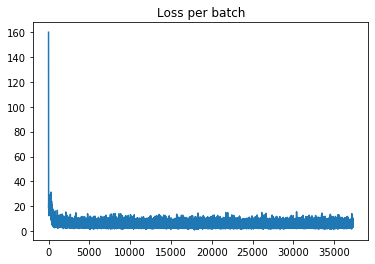

Saved in:  peptide-QML/checkpoints/0903/plots/0903-12h_em_losses_epochs_2.png


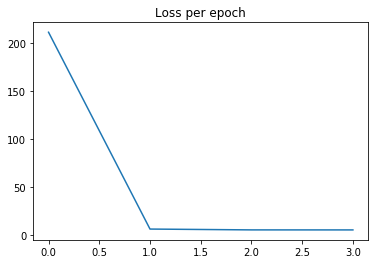

Saved in:  peptide-QML/checkpoints/0903/plots/0903-12h_em_losses_epochs_validation_2.png


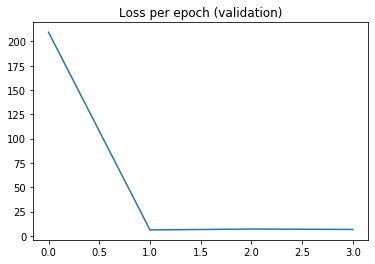

Saved in:  peptide-QML/checkpoints/0903/txts/0903-12h_em_losses_batches_2.txt
Saved in:  peptide-QML/checkpoints/0903/txts/0903-12h_em_losses_epochs_2.txt
Saved in:  peptide-QML/checkpoints/0903/txts/0903-12h_em_losses_epochs_validation_2.txt
Model saved as peptide-QML/checkpoints/0903/models/0903-12h_em_2.pth
Saved in:  peptide-QML/checkpoints/0903/plots/0903-12h_em_validation_2.png


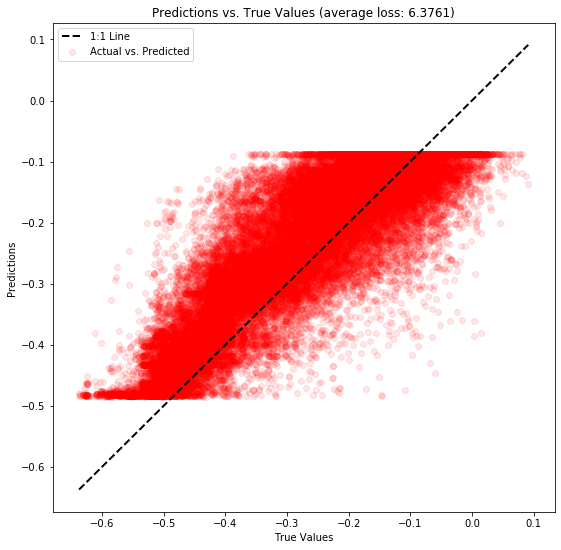

Saved in:  peptide-QML/checkpoints/0903/txts/0903-12h_em_validation_2.txt
0  # ------- block_n_layers:  1  ---- n_qubits:  5  ------- #




IndexError: index 5 is out of bounds for dimension 0 with size 5

In [3]:
dim = 12
day = "0903"


# -- DATA -- #

# name of the notebook
name_notebook = "{}-{}h_em.ipynb".format(day, dim)

# load data
data_file_path = '{}data/Scores/PET/PET_SCORES.csv'.format(initial_path)
string_list, number_list = f.read_data_file(
    data_file_path,
    skip_first_line=True, 
    delimiter=', ', 
    columns_to_return=[1, 2],
    which_columns_are_numbers=[2]
    )
score_list = np.array(number_list)/100
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) 
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)


# -- TRAINING LOOP -- #
for iii in range(5):

    for block_n_layers in range(1, 5):
        for n_qubits in range(4,7):
            print(iii, " # ------- block_n_layers: ", block_n_layers, " ---- n_qubits: ", n_qubits, " ------- #")
            print("")
            print("")

            quantum_layer = qn.circuit(
                n_qubits = n_qubits, 
                device = "default.qubit.torch",
                device_options = {'shots': None},
                embedding = qn.parts.AngleEmbedding, 
                # embedding_ansatz = qn.parts.Ansatz_11,
                block_ansatz = qn.parts.Ansatz_11,
                final_ansatz = qn.parts.Ansatz_final_11,
                measurement = qn.parts.Measurement('Z', 'all'),
                # embedding_n_layers = 4,
                # different_inputs_per_layer = True,
                block_n_layers = block_n_layers,
                # wrapper_qlayer = pw.QLayerEmpty,
            )

            # -- CLASSICAL MODEL -- #
            n_aminoacids = len(string_list[0])
            input_dim = input_data.shape[1]

            class Reshape(ptm.nn.Module):
                def __init__(self):
                    super(Reshape, self).__init__()

                def forward(self, x):
                    dims = len(x.shape)
                    return ptm.torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()
                
            embedding_dim = 4
            layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=embedding_dim), Reshape()]

            layers_dim = np.linspace(input_dim*embedding_dim, n_qubits, 4).astype(int)
            for i, o in zip(layers_dim[:-1], layers_dim[1:]):
                layers += [ptm.nn.Linear(i, o), ptm.nn.Sigmoid()]    # activation function RELU didn't work well  
            layers += [quantum_layer()]
            layers += [ptm.nn.Linear(n_qubits,1), ptm.nn.Sigmoid(), ptm.nn.Linear(1,1)]

            


            # Create model and set data:
            model = ptm.pytorch_model(
                layers,    
                save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
            )
            model.set_data(
                data_X=input_data, 
                data_Y=target_data, 
                data_X_validation=input_validation,
                data_Y_validation=target_validation
            )
            model.keep_track_params=False


            # -- TRAINING -- #
            import torch.optim as optim

            # train the model
            model.train(
                optimizer= optim.Adam,
                optimizer_options={'lr': 0.02},
                num_epochs = 3,                
                batch_size = 32,
                stop_training_options = {
                    'lookback_epochs': 5, 
                    'threshold_slope': 0.001,
                    'threshold_std_dev': 0.2
                },
            )

            # -- SAVE -- #

            # dump the object
            model.dump()

            # save string of the model
            model.save_str(
                metadata={
                    "data_file_path": data_file_path,
                    "n_aminoacids": n_aminoacids,
                    "block_n_layers": block_n_layers,
                    "n_qubits": n_qubits,
                    "embedding_dim": embedding_dim,
                    "quantum_layer": quantum_layer.__str__(),
                }
            )

            # plot the losses of the trainig loop and save the figures
            model.plot_losses(save=True, save_txt=True)

            #save all the parameters of the model and the intermediate parameters of the model
            model.save_state_dict(intermediate=False)

            # plot the validation and save it
            model.plot_validation(save=True, fig_size=(9,9), percentatge=1)

            # print validation and save it
            model.str_validation(save=True, precision=4, percentatge=1, printing=False)